##  导入依赖库
1. pandas，用于读取xlsx表格
2. base64，用于编码/解码算例文件
3. json，用于编码/解码json字符串
4. redis，用于服务器与客户端的通信
5. threading，用于发布/订阅的并发

In [1]:
import pandas as pd
import base64,json
import redis,threading
host = "localhost"

## 优化计算结果频道订阅
在接收到服务器的运行结果后，将其储存为excel文件

In [2]:
def read_response():
    r = redis.Redis(host=host,port=6379)
    print("opt_response channel subscribed")
    sub = r.pubsub()
    sub.subscribe("opt_response")
    resp = sub.parse_response()
    while 1:
        resp = sub.parse_response()
        resp = resp[2]
        print("message received")
        d = json.loads(resp)
        print(d["case_info"])
        for filename in ["agc","nonagc","wind"]:
            encoded_file = d[filename]
            filepath = d["ID"] + filename
            with open("../results/"+filepath+".csv","wb") as f:
                csv_file = base64.b64decode(encoded_file)
                f.write(csv_file)
                print("result saved as {0}".format(filepath))

## 建立redis连接

In [3]:
r = redis.Redis(host=host,port=6379)
print("connection established")

connection established


## 开始优化计算结果频道订阅

In [4]:
p = threading.Thread(target=read_response)
p.start()

opt_response channel subscribed


##  发布计算请求
1. 读取负荷预测、可再生能源预测Excel表
2. 读取算例文件
3. 结合用户参数配置，生成json消息
4. 发布到计算请求频道

In [73]:
load = pd.read_csv("../input/load data new.csv")
casefile = open("../input/case300.m",'rb')
# case_encoded = base64.b64encode(casefile.read())
case_encoded = casefile.read()
case_encoded_json = str(case_encoded, encoding = "utf-8")
for confidence in [98]:
    for k in [1]:#多目标权重循环
        df = pd.read_csv("../input/" + str(confidence) + "wind - 96.csv")
        WIND = [dict(bus=1,upper_bound=df["max"].tolist(),lower_bound=df["min"].tolist())]
        system_load = load["load96"].tolist()
        d = {"ID":str(confidence)+'_'+str(k),
            "WIND":WIND,
            "system_load":system_load,
            "case":case_encoded_json,
            "confidence":confidence,
            "windCur_weight":k,
            "Method":-1}
        json_msg = json.dumps(d)
        r.publish("opt_requests",json_msg)
        print('message sent')

message sent
message received
{'windPercentMax': 0.3, 'nbus': 300, 'totalLoadMin': 148.560774514461, 'ngen': 69, 'totalPmax': 326.78435, 'totalLoadMax': 261.42748, 'nbranch': 411, 'totalWindMin': 22.62828366837342, 'totalWindMax': 69.46874864851816}
result saved as 98_1agc
result saved as 98_1nonagc
result saved as 98_1wind


### with on_off var reduction
Best objective 9.527461382980e+06, best bound 9.526644262663e+06, gap 0.0086%, cpu time 38.52 seconds

### without on_off var reduction
Best objective 9.510280348464e+06, best bound 9.509412630681e+06, gap 0.0091%, cpu time 86.68 seconds

In [21]:
import pandas as pd
from scipy.interpolate import interp1d

In [39]:
df = pd.read_csv("../input/load data.csv")
df.head()
temp = df['load'].tolist()[0:24]
f = interp1d(range(24), temp,kind='cubic')

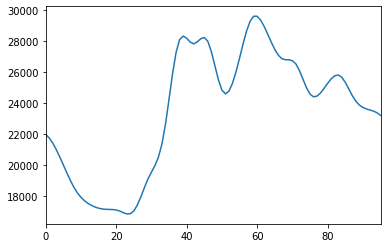

In [64]:
load_new = []
for t in range(96):
    y = f(23*t/96)
    load_new.append(float(y))
load_new = pd.Series(load_new)
load_new.plot()
# load_new.diff().plot()
df["load96"] = load_new
df.to_csv("../input/load data new.csv")